# Predicting student's test scores based on demographics, parental education, and preparation course completion.

Dataset is available at: https://www.kaggle.com/datasets/rkiattisak/student-performance-in-mathematics
Must download dataset from website above, then import as "exams.csv" file and run on colab, share link is https://colab.research.google.com/drive/14Tn6CYab3nWGgnpi34o9nHvUZcgdam51?usp=sharing

In [1]:
!pip install jovian opendatasets --upgrade --quiet
import opendatasets as od
import torch
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

## 1. Finding the Dataset Online:
The dataframe is a CSV file that stores information about 1000 students, available at  https://www.kaggle.com/datasets/rkiattisak/student-performance-in-mathematics. The information includes the students gender, ethnicity, parental level of education, lunch status, and test preparation course completion status. The goal for this project is to accurately predict the students test scores based on the information given. A portion of the dataframe is shown below.

In [2]:
dataset_url = 'https://www.kaggle.com/datasets/rkiattisak/student-performance-in-mathematics'
od.download(dataset_url)
data_dir = 'student-performance-in-mathematics'
import os
os.listdir(data_dir)


dataframe_raw = pd.read_csv('student-performance-in-mathematics/exams.csv')
dataframe_raw.head()

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: tienduong123
Your Kaggle Key: ········


100%|██████████| 8.66k/8.66k [00:00<00:00, 6.15MB/s]

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group D,some college,standard,completed,59,70,78
1,male,group D,associate's degree,standard,none,96,93,87
2,female,group D,some college,free/reduced,none,57,76,77
3,male,group B,some college,free/reduced,none,70,70,63
4,female,group D,associate's degree,standard,none,83,85,86


## 2. Preparing the Dataset
In order to work with the data better, the data needs to be seperated into numerical and categorical inputs, so that the machine can accurately calculate losses.
### 2a. Setting the input, categorical, and output columns

In [3]:
input_cols = ["parental level of education","lunch", "test preparation course"] #numerical inputs
categorical_cols = ['gender', 'race/ethnicity'] #Categorical inputs
output_cols = ['math score', 'reading score', 'writing score']

### 2b. Standardizing the Data using Pandas
Now we must standardize the numerical data so that the machine takes numerical values instead of textual values. We do this by changing the existing values to numerical ones. For example, parents with only some high school education would recieve a value of 0 whereas parents with a masters degree would recieve a value of 5.

In [4]:
#Standardizing lunch values
dataframe_raw.loc[dataframe_raw['lunch'] == "standard", 'lunch'] = 1
dataframe_raw.loc[dataframe_raw['lunch'] == "free/reduced", 'lunch'] = 0

#Standardizing Parental levels of education
dataframe_raw.loc[dataframe_raw['parental level of education'] == "some high school", 'parental level of education'] = 0
dataframe_raw.loc[dataframe_raw['parental level of education'] == "high school", 'parental level of education'] = 1
dataframe_raw.loc[dataframe_raw['parental level of education'] == "some college", 'parental level of education'] = 2
dataframe_raw.loc[dataframe_raw['parental level of education'] == "associate's degree", 'parental level of education'] = 3
dataframe_raw.loc[dataframe_raw['parental level of education'] == "bachelor's degree", 'parental level of education'] = 4
dataframe_raw.loc[dataframe_raw['parental level of education'] == "master's degree", 'parental level of education'] = 5

#Standardizing Test Preparation Course Completion
dataframe_raw.loc[dataframe_raw['test preparation course'] == "none", 'test preparation course'] = 0
dataframe_raw.loc[dataframe_raw['test preparation course'] == "completed", 'test preparation course'] = 1

#Showing first 10 values to make sure everything is properly standardized
df = dataframe_raw
df.head(10)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group D,2,1,1,59,70,78
1,male,group D,3,1,0,96,93,87
2,female,group D,2,0,0,57,76,77
3,male,group B,2,0,0,70,70,63
4,female,group D,3,1,0,83,85,86
5,male,group C,0,1,0,68,57,54
6,female,group E,3,1,0,82,83,80
7,female,group B,0,1,0,46,61,58
8,male,group C,0,1,0,80,75,73
9,female,group C,4,1,1,57,69,77


## 3. Training the Model
Now we must preparing dataset for training, by first converting the categorical inputs into categorical codes, and putting the inputs and outputs into numpy arrays.
### 3a. Putting data into numpy arrays then converting to tensors for torch to work with.

In [5]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

### 3b. Turning arrays into tensors for pytorch to use
The inputs and targets are now converted to tensors for pytorch to work with, and all converted to the datatype float32.

In [6]:
inputs_array, targets_array = dataframe_to_arrays(df)

inputs_array = inputs_array.astype('float32')
targets_array = targets_array.astype('float32')

inputs = torch.tensor(inputs_array).type(torch.float32)
targets = torch.tensor(targets_array).type(torch.float32)

dataset = TensorDataset(inputs, targets)
inputs_array, targets_array

(array([[2., 1., 1.],
        [3., 1., 0.],
        [2., 0., 0.],
        ...,
        [1., 1., 1.],
        [1., 1., 0.],
        [1., 1., 0.]], dtype=float32),
 array([[59., 70., 78.],
        [96., 93., 87.],
        [57., 76., 77.],
        ...,
        [67., 86., 86.],
        [80., 72., 62.],
        [58., 47., 45.]], dtype=float32))

### 3c. Splitting data into training and validation sets
The data is then split into training and validation sets.

In [7]:
num_rows = len(df)

val_percent = 0.10
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

### 3d. Setting the batch size and making the data loaders
The batch size is set and the loaders are made

In [8]:
batch_size = 100

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

### 3e. Creating the model
The model is then defined, and the architecture uses one hidden layer with a size of 30

In [9]:
class ExamsModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(len(input_cols), 30)
        self.linear2 = nn.Linear(30, len(output_cols))
        
    def forward(self, xb):
        out = xb.view(xb.size(0), -1)
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = torch.nn.functional.l1_loss(out,targets)
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = torch.nn.functional.l1_loss(out,targets)  
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

In [10]:
model = ExamsModel()

### 3f. Creating an evaluation function for predictions
An evaluation function is made to calculate losses and train the model for higher accuracy

In [11]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

The inital loss is very high, but will decrease as we continue to train it.

In [12]:
result = [evaluate(model, val_loader)] # Use the the evaluate function
print(result)


[{'val_loss': 66.71634674072266}]


## 4. Training Model
We will now begin to train the model, starting off with higher learning rates and decreasing them to lower the validation losses more efficiently.

In [13]:
epochs = 200
lr = 0.1
result += fit(epochs, lr, model, train_loader, val_loader)
%time

Epoch [20], val_loss: 11.0838
Epoch [40], val_loss: 10.5884
Epoch [60], val_loss: 10.5177
Epoch [80], val_loss: 10.5589
Epoch [100], val_loss: 10.6074
Epoch [120], val_loss: 10.4855
Epoch [140], val_loss: 10.5032
Epoch [160], val_loss: 11.1256
Epoch [180], val_loss: 10.6054
Epoch [200], val_loss: 10.4995
CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


In [14]:
epochs = 200
lr = 0.01
result += fit(epochs, lr, model, train_loader, val_loader)
%time

Epoch [20], val_loss: 10.7070
Epoch [40], val_loss: 10.6699
Epoch [60], val_loss: 10.6864
Epoch [80], val_loss: 10.6832
Epoch [100], val_loss: 10.7490
Epoch [120], val_loss: 10.6715
Epoch [140], val_loss: 10.7312
Epoch [160], val_loss: 10.7349
Epoch [180], val_loss: 10.7494
Epoch [200], val_loss: 10.7414
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


In [15]:
epochs = 200
lr = 0.001
result += fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 10.7174
Epoch [40], val_loss: 10.7162
Epoch [60], val_loss: 10.7143
Epoch [80], val_loss: 10.7156
Epoch [100], val_loss: 10.7136
Epoch [120], val_loss: 10.7123
Epoch [140], val_loss: 10.7137
Epoch [160], val_loss: 10.7104
Epoch [180], val_loss: 10.7080
Epoch [200], val_loss: 10.7070


In [16]:
epochs = 200
lr = 0.0001
result += fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 10.7073
Epoch [40], val_loss: 10.7076
Epoch [60], val_loss: 10.7078
Epoch [80], val_loss: 10.7077
Epoch [100], val_loss: 10.7073
Epoch [120], val_loss: 10.7072
Epoch [140], val_loss: 10.7069
Epoch [160], val_loss: 10.7068
Epoch [180], val_loss: 10.7067
Epoch [200], val_loss: 10.7066


## 5. Making predictions
A function is now defined to use the model to predict the test scores of a student.

In [17]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)                # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

The first person in the validation set is used, as we can see, the prediction is quite accurate considering the few parameters given to the machine.

In [18]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([2., 0., 0.])
Target: tensor([36., 45., 44.])
Prediction: tensor([59.8041, 62.7277, 60.9908])


## 6. Analyzing efficiency of model
We can now graph the losses over time to see how quickly the model learned as we changed the learning rates used.

In [19]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

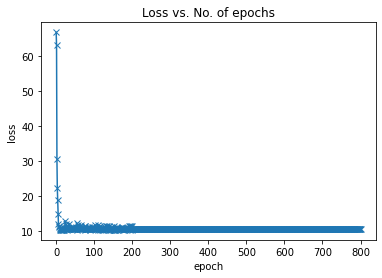

In [20]:
plot_losses(result)

## 7. Conclusions
#### Model recap:
The model was created using a kaggle dataframe that stored student demographics and test scores. The model would then use the demographics of the given student to predict 3 test scores. On average, the model was accurate for all the test scores, and only varied by 10 points off for all 3 scores on average. This means that for each test score, the model was only about 3 points off. Considering the relatively small input and relatively large output tensors required of the model, it is surprisingly accurate.

#### Training recap:
The model was trained first in vscode on the host computer. During training, a linear model was used as well as multiple feed forward neural networks. With trial and error, it was found that the model was most accurate with a singular layer feed forward neural network with the layer being a size of 30 hidden weights and biases. The linear model was nearly as accurate as the feed forward model, but was not as efficient and required more training in order to get to the save level of accuracy. More powerful models did not achieve the same level of accuracy as the current one did.

#### Insights:
The fact that a singular layer feed forward neural network worked best could tell us that the relationship between the input and output variables are linear. This could tell us the impact that demographics have on the student. Other factors not included in the dataset such as teacher skills, etc. could have a larger impact on the student.

#### Future research:
Different types of model architectures could be tried to find a more efficient or accurate model. However, if the dataset were to be increased with more data such as student iq, teacher skills, family income level, etc. then a more accurate model could be made. Training different models with fewer unique inputs could also give us insights on which factors are more influential on student test scores. For example, training the model with only family demographics may be more or less accurate than a model with only school/teacher demographics. A higher accuracy in either would suggest that the family/school is more influential on student test scores.

## 8. Saving to Jovian

In [23]:
project_name = "ffproject"

In [24]:
!pip install jovian --upgrade -q
import jovian
jovian.commit(project=project_name)

<IPython.core.display.Javascript object>

[jovian] Updating notebook "tien-t-duong/ffproject" on https://jovian.com
[jovian] Committed successfully! https://jovian.com/tien-t-duong/ffproject


'https://jovian.com/tien-t-duong/ffproject'